# Exploratory Data Analysis of Weather in Illinois

In [1]:
from pathlib import Path # Library used for handling paths
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import os # operating system module used for storing credentials into the environment variable
plt.style.use('default') # Ensures that my plots are made using a whitebackground.

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.cwd() / "secrets" / "my_credentials.json") # Credentials to be able to access the Google BigQuery public datasets

In [3]:
raw_temp_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_temp_data = pd.read_gbq(raw_temp_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery

Downloading:   0%|          |

In [4]:
raw_temp_data.drop(["qflag", "state", "id"], axis = 1, inplace = True) # Drop the qflag, state, and id columns
raw_temp_data["date"] = pd.to_datetime(raw_temp_data["date"]) # Convert the date column from a generic object type to a datetime object
raw_temp_data["value_degF"] = 9/5 * (raw_temp_data["value"] / 10) + 32 # Turn the value column which is in tenths of a degree Celsius to Fahrenheit
raw_temp_data.sort_values(by = "date", ignore_index = True, inplace = True) # Sort the temperatures by date
raw_temp_data = raw_temp_data[["date", "name", "element", "value", "value_degF", "latitude", "longitude"]] # Reorder the columns
raw_temp_data

,date,name,element,value,value_degF,latitude,longitude
0,1990-01-01,RANTOUL,TOBS,-39.0,24.98,40.3131,-88.1594
1,1990-01-01,BARRINGTON 3SW,TOBS,-56.0,21.92,42.1153,-88.1639
2,1990-01-01,DECATUR WTP,TMAX,0.0,32.00,39.8289,-88.9506
3,1990-01-01,PIPER CITY,TMIN,-56.0,21.92,40.7569,-88.1828
4,1990-01-01,BENTON 2 N,TMIN,-6.0,30.92,38.0336,-88.9203
...,...,...,...,...,...,...,...
4823851,2023-11-14,PITTSFIELD #2,TMAX,183.0,64.94,39.6197,-90.8033
4823852,2023-11-14,REND LAKE DAM,TMAX,194.0,66.92,38.0406,-88.9883
4823853,2023-11-14,MORRIS 1NW,TOBS,33.0,37.94,41.3714,-88.4333
4823854,2023-11-14,QUINCY DAM 21,TMAX,183.0,64.94,39.9036,-91.4283


In [5]:
raw_temp_data_pivot = raw_temp_data.pivot(columns = "element", values = "value_degF") # Converts the categorical data in the elements column to their own respective columns

In [6]:
transformed_temp_data = pd.concat([raw_temp_data, raw_temp_data_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_temp_data.drop(["element", "value", "value_degF"], axis = 1, inplace = True) # drop the element and value columns
temp_only_df = transformed_temp_data[["date", "TMIN", "TMAX", "TAVG", "TOBS"]] # Keep just the temperature and date columns

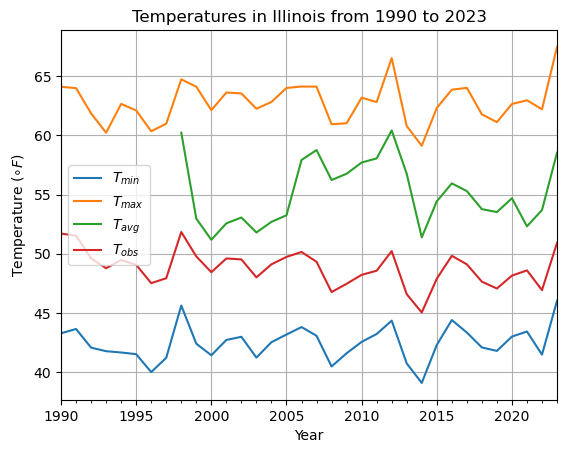

In [7]:
# This code plots the minimum, maximum, average, and observed temperatures
ax = (temp_only_df.resample("Y", on = "date").mean() # Resample the temperature dataframe over one year (originally was sampled per day)
      .plot(xlabel = "Year", ylabel = r"Temperature ($\circ F$)", 
            grid = True, title = "Temperatures in Illinois from 1990 to 2023"))
ax.legend(loc = "best", labels = [r"$T_{min}$", r"$T_{max}$", r"$T_{avg}$", r"$T_{obs}$"]) # Format the temperature labels

In [8]:
raw_temp_data.groupby("element")["value"].count().apply(lambda x: f"{x:,}") # number of observations that were taken per category

element
TAVG       88,621
TMAX    1,665,961
TMIN    1,657,371
TOBS    1,411,903
Name: value, dtype: object

In [9]:
raw_temp_data.groupby("element")["value"].count().apply(lambda x: f"{x / len(raw_temp_data) * 100:,.2f}") # percentage of observations per category

element
TAVG     1.84
TMAX    34.54
TMIN    34.36
TOBS    29.27
Name: value, dtype: object

In [10]:
transformed_temp_data["name"].nunique() # number of stations in Illinois

209

In [11]:
transformed_temp_data["name"].unique() # list of all the station names

array(['RANTOUL', 'BARRINGTON 3SW', 'DECATUR WTP', 'PIPER CITY',
       'BENTON 2 N', 'WHITE HALL 1 E', 'JOLIET BRANDON ROAD LOCK/DAM',
       'SALEM', 'SPARTA 1 W', 'PERU', 'PAXTON 2 WSW', 'WATERLOO 6SW',
       'ROSICLARE 5NW', 'CHARLESTON', 'CHICAGO OHARE INTL AP',
       'HOOPESTON', 'GALVA', 'VIRDEN', 'PARIS STP', 'NASHVILLE 1 E',
       'ROCK ISLAND L&D 15', 'MATTOON', 'MARENGO', 'MARION 4 NNE',
       'FAIRFIELD RADIO WFIW', 'QUINCY RGNL AP', 'NORMAL 4NE',
       'WHEATON 3 SE', 'OLIVE BRANCH', 'PAW PAW 2S', 'MCLEANSBORO',
       'CARLINVILLE', 'LAKE VILLA 2NE', 'HAVANA', 'WALNUT',
       'CARBONDALE SEWAGE PLT', 'FULTON L&D #13', 'LACON', 'ROCHELLE',
       'VANDALIA', 'CHAMPAIGN 3S', 'WAUKEGAN', 'TISKILWA 2 SE',
       'MT CARMEL', 'BROOKPORT DAM 52', 'GALESBURG', 'CHENOA', 'ANNA 4 N',
       'NEWTON 6 SSE', 'MT VERNON 3 NE', 'CHICAGO MIDWAY AP 3SW',
       'MORRISONVILLE', 'RUSHVILLE', 'FARMER CITY 3W',
       'CHICAGO BOTANIC GARDEN', 'PONTIAC', 'DIXON SPRINGS AGRIC CTR',
  

In [21]:
num_obs_per_station = transformed_temp_data.filter(regex = "name|T+", axis = 1).groupby("name", as_index = False).count()
num_obs_per_station

,name,TAVG,TMAX,TMIN,TOBS
0,ALBION,0,5233,5072,5047
1,ALEDO,0,11915,11892,11894
2,ALTON - MELVIN PRICE L&D,0,10633,10295,10656
3,ALTONA,0,6005,5991,5822
4,ANNA 4 N,0,8675,8720,8258
...,...,...,...,...,...
204,WAUKEGAN,0,4340,4058,3986
205,WHEATON 3 SE,0,7686,7736,6652
206,WHITE HALL 1 E,0,12197,12155,12099
207,WINCHESTER,0,5811,5782,5782
